In [23]:
import wikitables # To get Porto Alegre districts' names from Wikipedia page
from geopy.geocoders import Nominatim # To get districts' (lat,long) coords
import numpy as np # For math
import copy # For deep copy
import json # For JSON
import os # To check if file exists
from matplotlib import pyplot as plt # To show histogram

In [14]:
# To compute distance between two (lat,long) coords on the globe (for those of us who believe the earth is round)
def haversine_distance(lat1, long1, lat2, long2):
    phi1 = (90.0 - lat1)*np.pi/180.0
    phi2 = (90.0 - lat2)*np.pi/180.0
    theta1 = long1*np.pi/180.0
    theta2 = long2*np.pi/180.0
    cos = min(1,np.sin(phi1)*np.sin(phi2)*np.cos(theta1 - theta2) + np.cos(phi1)*np.cos(phi2))
    arc = np.acos(cos)
    return 6373*arc
#end

In [15]:
# Obtain district names from Wikipedia
district_names = [str(row['Bairro']) for row in wikitables.import_tables('Lista_de_bairros_de_Porto_Alegre','pt')[0].rows][:-2]

In [16]:
# Obtain geolocator
geolocator = Nominatim()

/home/marcelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.19.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [18]:
# Download districts' locations and save into JSON file
if not os.path.isfile('district_locations.json'):
    district_locations = {}
    for district in district_names:
        location = geolocator.geocode(f'{district}, Porto Alegre')
        district_locations[district] = (location.latitude, location.longitude)
        print(f'{district} lat={location.latitude} lon={location.longitude}')
    #end
#end
district_locations = json.load(open('district_locations.json','r'))

In [19]:
# Compute distance matrix
distance_matrix = {}
for d1 in district_names:
    for d2 in district_names:
        lat1,lon1 = district_locations[d1]
        lat2,lon2 = district_locations[d2]
        distance_matrix[(d1,d2)] = haversine_distance(lat1,lon1,lat2,lon2)
    #end
#end

In [20]:
# Precompute enemies (initially, each district is enemy to every other district)
# We represent this as a dictionary of district names to a sorted list of its closest enemies
enemies_precomputed = { district:sorted(district_names, key=lambda x: distance_matrix[district,x]) for district in district_names }
for district in district_names: enemies_precomputed[district].remove(district);

In [21]:
# Define simulation procedure
def simulate():
    
    # Init map of occupations
    occupied_by = { district:district for district in district_names }

    # List of districts which are still in the game
    players = district_names.copy()

    # List of (distance-sorted) enemy districts for each district
    enemies = copy.deepcopy(enemies_precomputed)

    # Simulate
    while len(players) > 1:
        # Choose a random district
        random_district = np.random.choice(district_names)
        # If random district is occupied, the occupier becomes the attacking district
        attacking_district = occupied_by[random_district]
        # Get closest enemy district
        closest_enemy = enemies[random_district][0]
        # If closest enemy is occupied, the occupier becomes the defending district
        defending_district = occupied_by[closest_enemy]
        # Update occupations and enemy lists
        for i,district in enumerate(district_names):
            if occupied_by[district] == defending_district:
                for district_ in district_names:
                    if occupied_by[district_] == attacking_district:
                        # Districts occupied by the attacking and defending districts are not enemies anymore
                        if district_ in enemies[district]: enemies[district].remove(district_)
                        if district in enemies[district_]: enemies[district_].remove(district)
                    #end
                #end
                # Districts occupied by the defending district are now occupied by the attacking district
                occupied_by[district] = attacking_district
            #end
        #end
        # The defending district is out of the game
        players.remove(defending_district)
    #end
    # Return winner
    return players[0]
#end

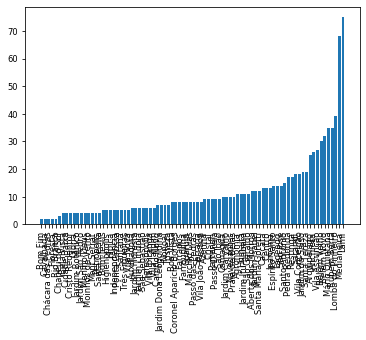

In [25]:
# Run simulations and keep track of winners
simulations = 10**3
wins = { district:0 for district in district_names }
for i in range(simulations):
    winner = simulate()
    wins[winner] += 1
#end

# Plot histogram
sorted_districts = sorted(district_names, key=lambda x: wins[x])
plt.bar(sorted_districts, [wins[x] for x in sorted_districts])
plt.xticks(rotation='vertical')
plt.tick_params(labelsize='small')
plt.show()